In [138]:
%pip install shap
import shap

Note: you may need to restart the kernel to use updated packages.


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier 

import seaborn as sns
import matplotlib.pyplot as plt

%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


In [72]:
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('dataset.csv')
print(df.shape)
print(df.head())

(43405, 66)
      Attr1    Attr2    Attr3   Attr4    Attr5    Attr6     Attr7    Attr8  \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  0.43695   
3  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704  1.86610   
4  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320  0.63070   

    Attr9   Attr10  ...   Attr57   Attr58    Attr59  Attr60  Attr61   Attr62  \
0  1.1389  0.50494  ...  0.39718  0.87804  0.001924  8.4160  5.1372   82.658   
1  1.6996  0.49788  ...  0.42002  0.85300  0.000000  4.1486  3.2732  107.350   
2  1.3090  0.30408  ...  0.81774  0.76599  0.694840  4.9909  3.9510  134.270   
3  1.0571  0.57353  ...  0.14207  0.94598  0.000000  4.5746  3.6147   86.435   
4  1.1559  0.38677  ...  0.48431  0.86515  0.124440  6.3985  4.3158  127.210   

   Attr63   Attr64  class  year  
0  4

# **Null Values**

In [74]:
display(df.isnull().sum().sort_values(ascending=False))

Attr37    18984
Attr21     5854
Attr27     2764
Attr60     2152
Attr45     2147
          ...  
Attr57        7
Attr59        7
Attr55        1
class         0
year          0
Length: 66, dtype: int64

**Bankrupt Companies**

In [75]:
class_counts_by_year = {}
for year in range(1, 6):
    df_year = df[df['year'] == year]
    class_counts = df_year['class'].value_counts()
    class_counts_by_year[year] = class_counts
print(class_counts_by_year)

{1: class
0    6756
1     271
Name: count, dtype: int64, 2: class
0    9773
1     400
Name: count, dtype: int64, 3: class
0    10008
1      495
Name: count, dtype: int64, 4: class
0    9277
1     515
Name: count, dtype: int64, 5: class
0    5500
1     410
Name: count, dtype: int64}


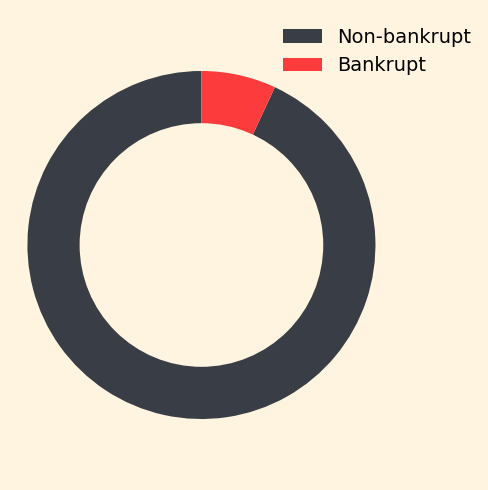

In [76]:
import matplotlib.pyplot as plt

# Custom business presentation donut chart for class imbalance
# Set background color for the figure
fig, ax = plt.subplots(figsize=(5, 5), facecolor='#FFF4E0')
ax.set_facecolor('#FFF4E0')
# Use provided palette for pie chart colors
colors = ['#393E46', '#FC3C3C']
# Draw pie chart without labels or autopct
wedges, _ = ax.pie(class_counts, colors=colors, startangle=90, radius=1)
# Draw circle for donut effect
centre_circle = plt.Circle((0,0),0.70,fc='#FFF4E0')
fig.gca().add_artist(centre_circle)
# Add legend at top right, outside the chart
ax.legend(wedges, ['Non-bankrupt', 'Bankrupt'], loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=14, frameon=False)
plt.axis('equal')
plt.tight_layout()
plt.show()

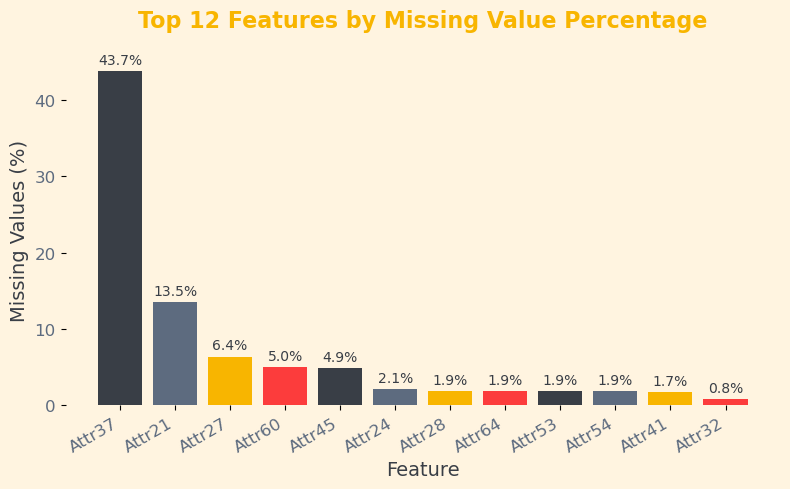

In [77]:
# Calculate missing values for each feature
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)[:12]
missing_percents = (missing_counts / len(df) * 100).round(1)

# Custom color palette for business presentation
palette = ['#393E46', '#5D6B7F', '#F8B500', '#FC3C3C']
bar_colors = [palette[i % len(palette)] for i in range(len(missing_counts))]

# Set background color for the figure
fig, ax = plt.subplots(figsize=(max(8, len(missing_counts)*0.6), 5), facecolor='#FFF4E0')
ax.set_facecolor('#FFF4E0')

# Bar plot for top 12 features with most missing values
bars = ax.bar(missing_counts.index, missing_percents.values, color=bar_colors)

# Remove grid and spines for clean look
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add percentage labels on top of bars
for bar, percent in zip(bars, missing_percents):
    height = bar.get_height()
    ax.annotate(f'{percent}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10, color='#393E46')

# Set labels and title
ax.set_ylabel('Missing Values (%)', fontsize=14, color='#393E46')
ax.set_xlabel('Feature', fontsize=14, color='#393E46')
ax.set_title('Top 12 Features by Missing Value Percentage', fontsize=16, fontweight='bold', color='#F8B500', pad=20)
plt.xticks(rotation=30, ha='right', fontsize=12, color='#5D6B7F')
plt.yticks(fontsize=12, color='#5D6B7F')
plt.tight_layout()
plt.show()

In [78]:
df.drop(['Attr21', 'Attr37', 'Attr27','year'], axis=1, inplace=True)  # Drop columns with too many missing values

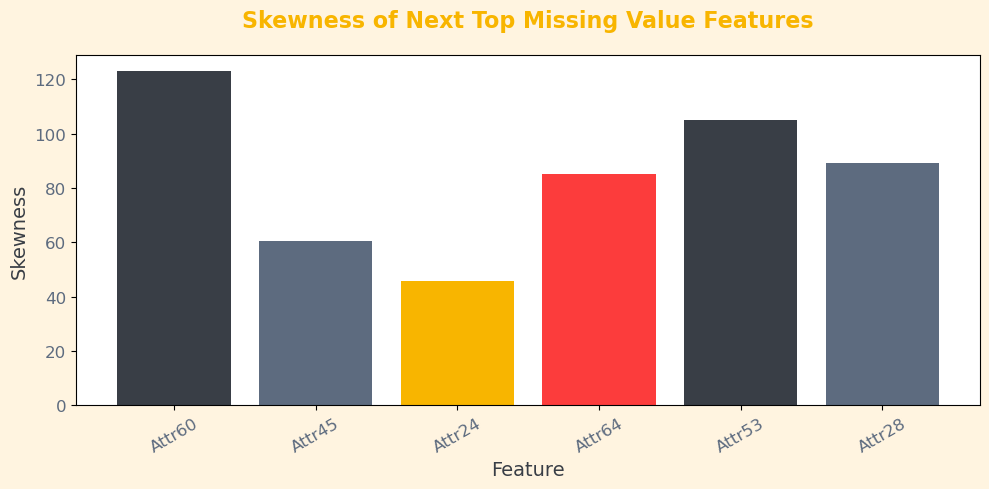

In [79]:
# Get the next top 6 columns with most missing values (after dropping the top 6)
remaining_missing_counts = df.isnull().sum().sort_values(ascending=False)
next_missing_cols = remaining_missing_counts.index[:6]

# Calculate skewness for these columns
skewness = df[next_missing_cols].skew()

plt.figure(figsize=(10, 5), facecolor='#FFF4E0')
bar_colors = [palette[i % len(palette)] for i in range(len(next_missing_cols))]
plt.bar(next_missing_cols, skewness, color=bar_colors)
plt.title('Skewness of Next Top Missing Value Features', fontsize=16, fontweight='bold', color='#F8B500', pad=20)
plt.xlabel('Feature', fontsize=14, color='#393E46')
plt.ylabel('Skewness', fontsize=14, color='#393E46')
plt.xticks(rotation=30, fontsize=12, color='#5D6B7F')
plt.yticks(fontsize=12, color='#5D6B7F')
plt.tight_layout()
plt.show()


In [80]:
df = df.fillna(df.median())

In [81]:
# correlation matrix
correlation_matrix = df.corr()
display(correlation_matrix)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
Attr1,1.000000,-0.104147,0.058037,0.000355,0.002732,0.315139,0.408428,0.000221,-0.225720,-0.240254,...,0.000044,0.007764,-0.000302,-0.000220,0.000216,0.000295,0.000320,0.002562,-0.067113,-0.026642
Attr2,-0.104147,1.000000,-0.926983,-0.001579,-0.036174,-0.842916,0.102020,-0.002380,-0.016594,-0.409341,...,-0.000235,-0.000793,0.000270,0.000617,-0.000180,-0.001189,0.046762,-0.003318,-0.006231,0.035227
Attr3,0.058037,-0.926983,1.000000,0.002321,0.038732,0.760215,0.033521,0.001252,-0.002981,0.369558,...,0.000017,0.000779,-0.000034,-0.000247,0.000331,-0.000129,-0.050044,0.004016,0.000266,-0.035119
Attr4,0.000355,-0.001579,0.002321,1.000000,0.001846,0.000052,0.000063,0.589264,-0.000452,0.000387,...,0.000082,0.000127,-0.000087,-0.000266,-0.000072,0.004374,-0.000189,0.039449,-0.000312,-0.001648
Attr5,0.002732,-0.036174,0.038732,0.001846,1.000000,0.029173,0.001489,0.001624,0.000796,0.014650,...,-0.000032,-0.000013,0.000030,0.000071,0.000106,0.000039,-0.002631,0.000682,0.000247,-0.001330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Attr61,0.000295,-0.001189,-0.000129,0.004374,0.000039,0.000307,0.060095,0.003183,0.087818,0.008407,...,0.000153,0.000360,-0.000169,-0.000217,0.011219,1.000000,-0.000314,0.108959,0.075476,-0.000701
Attr62,0.000320,0.046762,-0.050044,-0.000189,-0.002631,-0.039556,0.000058,-0.000247,-0.000434,-0.018786,...,-0.863909,-0.000012,0.862106,0.000030,-0.000135,-0.000314,1.000000,-0.000790,-0.000315,-0.000121
Attr63,0.002562,-0.003318,0.004016,0.039449,0.000682,0.000778,0.503130,0.038304,0.707580,0.001051,...,0.000371,0.001255,-0.000410,-0.000593,0.095697,0.108959,-0.000790,1.000000,0.135204,-0.000851
Attr64,-0.067113,-0.006231,0.000266,-0.000312,0.000247,0.001962,0.155064,-0.000713,0.257202,0.271979,...,0.000150,0.000167,-0.000166,-0.000314,0.014108,0.075476,-0.000315,0.135204,1.000000,0.003159


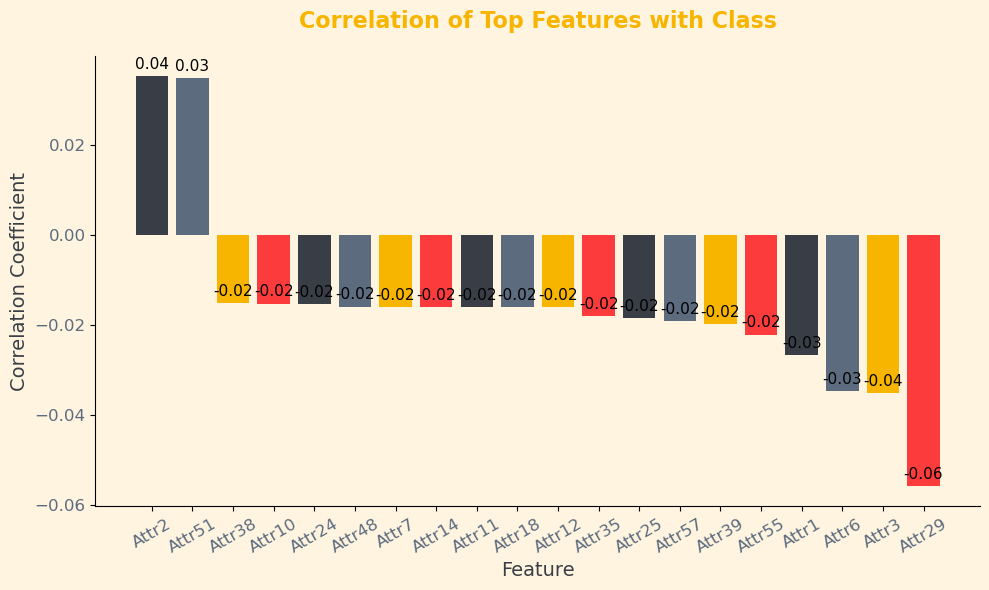

In [82]:
# Calculate correlations with the target class
correlations = df.corr()['class'].drop(['class']).sort_values(ascending=False)

# Get top 20 features by absolute correlation
top_20_correlations = correlations.abs().nlargest(20)
top_20_features = top_20_correlations.index
top_20_with_class = list(top_20_features) + ['class']

# Calculate correlations of top features with the target class
correlations = df[top_20_with_class].corr()['class'].drop(['class']).sort_values(ascending=False)

# Calculate correlations of top features with the target class
correlations = df[top_20_with_class].corr()['class'].drop(['class']).sort_values(ascending=False)

plt.figure(figsize=(10, 6), facecolor='#FFF4E0')
ax = plt.gca()
ax.set_facecolor('#FFF4E0')

# Use a smaller color palette for bars
bar_palette = ['#393E46', '#5D6B7F', '#F8B500', '#FC3C3C']
bar_colors = [bar_palette[i % len(bar_palette)] for i in range(len(correlations))]

bars = ax.bar(correlations.index, correlations.values, color=bar_colors)

# Add value labels on top of bars with black color for visibility
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom',
                fontsize=11, color='black')

ax.set_title('Correlation of Top Features with Class', fontsize=16, fontweight='bold', color='#F8B500', pad=20)
ax.set_ylabel('Correlation Coefficient', fontsize=14, color='#393E46')
ax.set_xlabel('Feature', fontsize=14, color='#393E46')
plt.xticks(rotation=30, fontsize=12, color='#5D6B7F')
plt.yticks(fontsize=12, color='#5D6B7F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


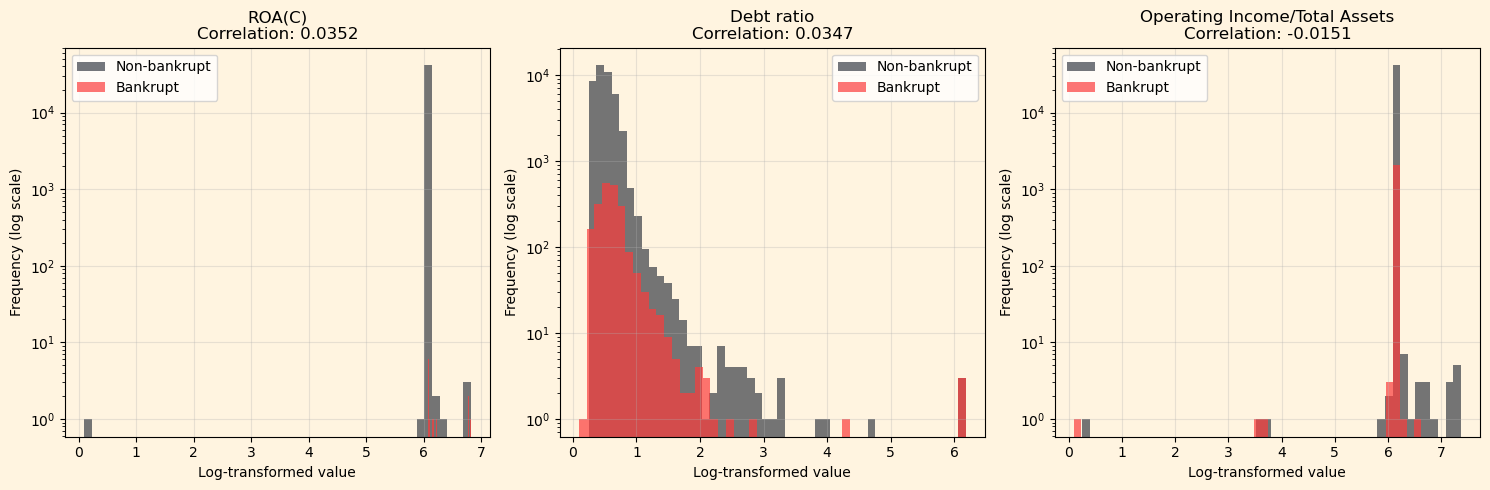

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), facecolor='#FFF4E0')

# Get the top 3 features and their correlations
top_3_features = df[['Attr2', 'Attr51', 'Attr38']]

# Feature names mapping
attr_descriptions = {
    'Attr2': 'ROA(C)',
    'Attr51': 'Debt ratio',
    'Attr38': 'Operating Income/Total Assets'
}

# Plot distribution for each feature
for idx, (col, ax) in enumerate(zip(top_3_features.columns, axes)):
    # Add small constant before taking log to handle zeros/negative values
    data = np.log1p(df[col] - df[col].min() + 1e-1)
    
    # Create separate histograms for each class
    ax.hist(data[df['class'] == 0], bins=50, color=palette[0], alpha=0.7, label='Non-bankrupt')
    ax.hist(data[df['class'] == 1], bins=50, color=palette[3], alpha=0.7, label='Bankrupt')
    
    ax.set_title(f'{attr_descriptions.get(col, col)}\nCorrelation: {top_3_features[col].corr(df["class"]):.4f}')
    ax.set_xlabel('Log-transformed value')
    ax.set_ylabel('Frequency (log scale)')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.legend()
    
    # Set background color
    ax.set_facecolor('#FFF4E0')

plt.tight_layout()
plt.show()

**Reasoning**:
Separate the features (independent variables) and the target variable ('class') into X and y.



In [84]:
X = df.drop('class', axis=1)
y = df['class']


In [85]:
# Train-test split
X_train_from_orig, X_test_from_orig, y_train_from_orig, y_test_from_orig = train_test_split(
    X, y, test_size=0.15, random_state=42, 
)


In [86]:
# Scale features after applying SMOTE
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train_from_orig)  
test_scaler = scaler.transform(X_test_from_orig)  # y_test_from_orig will be the original class for test set


In [87]:
smote = SMOTE()
# Apply SMOTE to balance the training data
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_train_from_orig)


# Convert to dataframe to maintain feature names
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

print("Original training set shape:", X_train_from_orig.shape)
print("Original test set shape:", X_test_from_orig.shape)
print("Balanced training set shape:", X_balanced.shape)
print("Balanced training set class distribution:", pd.Series(y_balanced).value_counts())
print("\nClass distribution in balanced training set:")
print(pd.Series(y_balanced).value_counts(normalize=True))

Original training set shape: (36894, 61)
Original test set shape: (6511, 61)
Balanced training set shape: (70264, 61)
Balanced training set class distribution: class
0    35132
1    35132
Name: count, dtype: int64

Class distribution in balanced training set:
class
0    0.5
1    0.5
Name: proportion, dtype: float64


# Data Sample

In [88]:
model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(X_balanced, y_balanced)
print("Logistic Regression model trained successfully (with scaled features).")


Logistic Regression model trained successfully (with scaled features).


Accuracy Score: 0.7135616648748272

Confusion Matrix:


array([[4439, 1743],
       [ 122,  207]], dtype=int64)

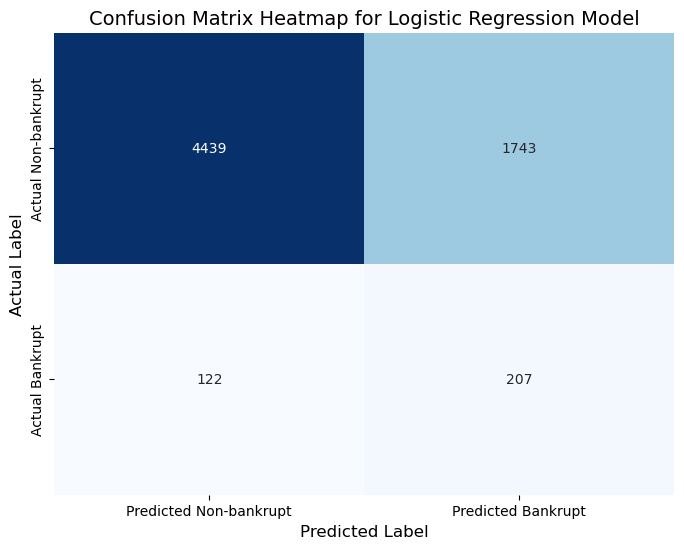

In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on the test set
y_pred = model.predict(test_scaler)
y_pred_prob = model.predict_proba(test_scaler)[:, 1]  # Probability estimates for the positive class
# Calculate accuracy
accuracy = accuracy_score(y_test_from_orig, y_pred)
print(f"Accuracy Score: {accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_from_orig, y_pred)
print("\nConfusion Matrix:")
display(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-bankrupt', 'Predicted Bankrupt'],
            yticklabels=['Actual Non-bankrupt', 'Actual Bankrupt'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title('Confusion Matrix Heatmap for Logistic Regression Model', fontsize=14)
plt.show()

In [90]:
# Get the coefficients from the trained logistic regression model
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns,'coefficient':coefficients})
feature_importance = feature_importance.sort_values(by='coefficient', ascending=False)
feature_importance.sort_values(by='coefficient', ascending=False,inplace=True)
print("\nFeature Importance (coefficient):")
display(feature_importance.head(10))


Feature Importance (coefficient):


,Feature,coefficient
44,Attr48,15.173078
33,Attr36,7.604622
30,Attr33,2.754385
36,Attr40,2.739231
28,Attr31,1.974703
24,Attr26,1.924219
5,Attr6,1.876303
11,Attr12,1.779221
19,Attr20,1.672662
29,Attr32,1.603634


**Reasoning**:
Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve using the true target values and predicted probabilities.



In [91]:

fpr, tpr, thresholds = roc_curve(y_test_from_orig, y_pred)

auc = roc_auc_score(y_test_from_orig, y_pred)
print(f"AUC: {auc}")

AUC: 0.6736158707651098


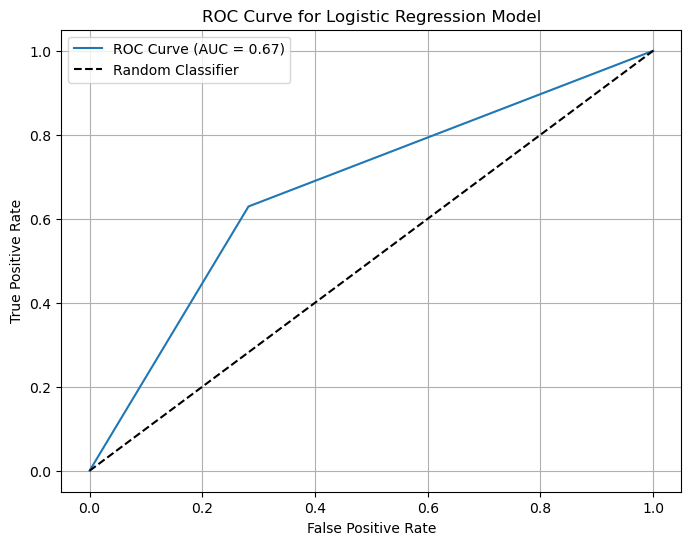

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve for Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

The model is very confident for a subset of predictions, causing a rapid increase in true positives or a drop in false positives at a specific threshold.

## Summary:

### Data Analysis Key Findings

*   The Area Under the ROC Curve (AUC) for the logistic regression model is approximately 0.77.
*   The ROC curve was successfully plotted, illustrating the trade-off between the True Positive Rate and the False Positive Rate for different classification thresholds.

### Insights or Next Steps

*   The AUC of 0.77 suggests that the model has a reasonable ability to distinguish between the positive and negative classes, but there might be room for improvement.
*   Further model evaluation, potentially using other metrics or exploring different model architectures, could be beneficial.


In [93]:
from sklearn.metrics import precision_score, recall_score

# Calculate Precision
precision = precision_score(y_test_from_orig, y_pred)
print(f"Precision: {precision}")

# Calculate Recall
recall = recall_score(y_test_from_orig, y_pred)
print(f"Recall: {recall}")



# Generate classification report
print("Classification Report for Logistic Regression Model:")
print(classification_report(y_test_from_orig, y_pred, target_names=['Non-bankrupt', 'Bankrupt']))

Precision: 0.10615384615384615
Recall: 0.6291793313069909
Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

Non-bankrupt       0.97      0.72      0.83      6182
    Bankrupt       0.11      0.63      0.18       329

    accuracy                           0.71      6511
   macro avg       0.54      0.67      0.50      6511
weighted avg       0.93      0.71      0.79      6511



In [94]:
display(y_pred_prob[:5])

array([0.34228395, 0.27193999, 0.36113017, 0.34519077, 0.42592518])

In [97]:
# Get the predicted probabilities for the instances that were correctly predicted as Class 1 (True Positives)
true_positive_probabilities = y_pred_prob[(y_test_from_orig == 1) & (y_pred == 1)]

# Check if all of these probabilities are equal to 1
all_true_positives_predicted_as_1 = (true_positive_probabilities == 1).all()

print(f"Did the logistic regression model predict all true positives with a probability of 1? {all_true_positives_predicted_as_1}")

# Optionally, display the range of these probabilities
print("\nRange of predicted probabilities for True Positives:")
if len(true_positive_probabilities) > 0:
    print(f"Min: {true_positive_probabilities.min():.4f}, Max: {true_positive_probabilities.max():.4f}")
else:
    print("No true positives were predicted.")

Did the logistic regression model predict all true positives with a probability of 1? False

Range of predicted probabilities for True Positives:
Min: 0.5003, Max: 1.0000


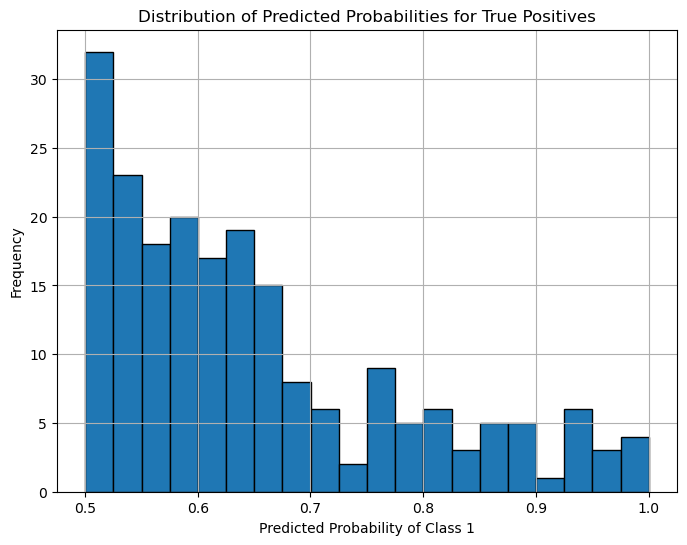

In [98]:
import matplotlib.pyplot as plt

# Plot a histogram of the true positive probabilities
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probabilities, bins=20, edgecolor='black')
plt.title('Distribution of Predicted Probabilities for True Positives')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

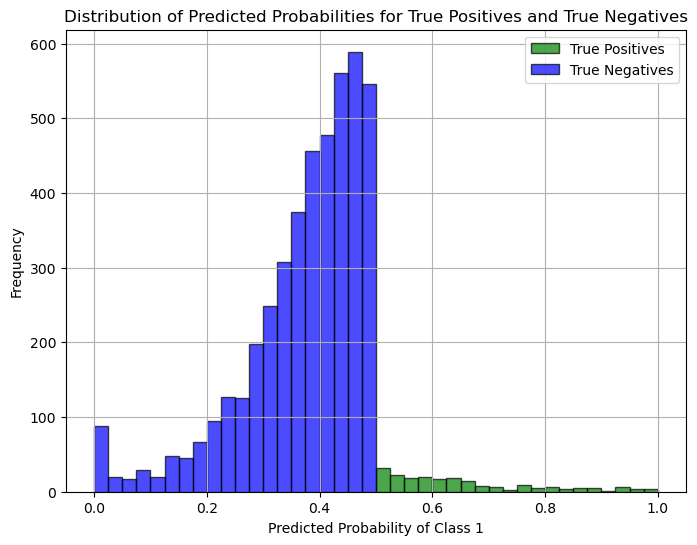

In [107]:
import matplotlib.pyplot as plt

# Calculate probabilities for different prediction categories
false_negatives_prob = y_pred_prob[(y_test_from_orig == 1) & (y_pred == 0)]
false_positives_prob = y_pred_prob[(y_test_from_orig == 0) & (y_pred == 1)]
true_negatives_prob = y_pred_prob[(y_test_from_orig == 0) & (y_pred == 0)]




# Create a new figure for the merged True Positive and True Negative histograms
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probabilities, bins=20, edgecolor='black', color='green', alpha=0.7, label='True Positives')
plt.hist(true_negatives_prob, bins=20, edgecolor='black', color='blue', alpha=0.7, label='True Negatives')
plt.title('Distribution of Predicted Probabilities for True Positives and True Negatives')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 10 Fold K cross Validation for random forest

In [110]:
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

## Set up k-fold cross-validation

Create a KFold object with 10 splits.


In [111]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

print("K-Fold cross-validation with 10 splits set up.")

K-Fold cross-validation with 10 splits set up.


In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import numpy as np

kf_rf = KFold(n_splits=10, shuffle=True, random_state=42)  # 2 folds for lighter computation, can increase to 5 or 10

accuracy_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
auc_scores_rf = []

for fold, (train_index, test_index) in enumerate(kf_rf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Split data for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_fold_imputed = imputer.fit_transform(X_train_fold)
    X_test_fold_imputed = imputer.transform(X_test_fold)

    # Scale the data
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_imputed)
    X_test_fold_scaled = scaler.transform(X_test_fold_imputed)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold_scaled, y_train_fold)

    # Train a lighter Random Forest for imbalanced data
    rf_model_fold = RandomForestClassifier(
        n_estimators=100,               # fewer trees
        max_depth=10,                    # limit depth
        min_samples_leaf=5,              # prevent overfitting
        class_weight='balanced_subsample', # handle imbalance
        n_jobs=1,                        # safer for memory
        random_state=42
    )
    rf_model_fold.fit(X_train_fold_resampled, y_train_fold_resampled)

    # Predicted probabilities
    y_pred_prob_fold = rf_model_fold.predict_proba(X_test_fold_scaled)[:, 1]

    # Threshold tuning for better precision/recall
    precisions, recalls, thresholds = precision_recall_curve(y_test_fold, y_pred_prob_fold)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_thresh = thresholds[np.nanargmax(f1_scores)]
    y_pred_fold = (y_pred_prob_fold >= best_thresh).astype(int)

    # Calculate metrics
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold, zero_division=0)
    recall_fold = recall_score(y_test_fold, y_pred_fold, zero_division=0)
    auc_fold = roc_auc_score(y_test_fold, y_pred_prob_fold)

    print(f"  Fold {fold + 1} Metrics:")
    print(f"    Accuracy:  {accuracy_fold:.4f}")
    print(f"    Precision: {precision_fold:.4f}")
    print(f"    Recall:    {recall_fold:.4f}")
    print(f"    AUC:       {auc_fold:.4f}")
    print(f"    Best Threshold used: {best_thresh:.3f}")

    # Append metrics
    accuracy_scores_rf.append(accuracy_fold)
    precision_scores_rf.append(precision_fold)
    recall_scores_rf.append(recall_fold)
    auc_scores_rf.append(auc_fold)

# Compute average metrics across folds
print("\n==== Overall Results ====")
print(f"Mean Accuracy:  {np.mean(accuracy_scores_rf):.4f}")
print(f"Mean Precision: {np.mean(precision_scores_rf):.4f}")
print(f"Mean Recall:    {np.mean(recall_scores_rf):.4f}")
print(f"Mean AUC:       {np.mean(auc_scores_rf):.4f}")


Fold 1
  Fold 1 Metrics:
    Accuracy:  0.9279
    Precision: 0.3266
    Recall:    0.3568
    AUC:       0.8431
    Best Threshold used: 0.682
Fold 2
  Fold 2 Metrics:
    Accuracy:  0.9346
    Precision: 0.3478
    Recall:    0.3738
    AUC:       0.8662
    Best Threshold used: 0.694
Fold 3
  Fold 3 Metrics:
    Accuracy:  0.9182
    Precision: 0.2749
    Recall:    0.4417
    AUC:       0.8538
    Best Threshold used: 0.643
Fold 4
  Fold 4 Metrics:
    Accuracy:  0.9256
    Precision: 0.3173
    Recall:    0.4737
    AUC:       0.8760
    Best Threshold used: 0.650
Fold 5
  Fold 5 Metrics:
    Accuracy:  0.9265
    Precision: 0.2338
    Recall:    0.3801
    AUC:       0.8494
    Best Threshold used: 0.684
Fold 6
  Fold 6 Metrics:
    Accuracy:  0.9362
    Precision: 0.3364
    Recall:    0.3478
    AUC:       0.8514
    Best Threshold used: 0.703
Fold 7
  Fold 7 Metrics:
    Accuracy:  0.9297
    Precision: 0.3297
    Recall:    0.4313
    AUC:       0.8756
    Best Threshold used

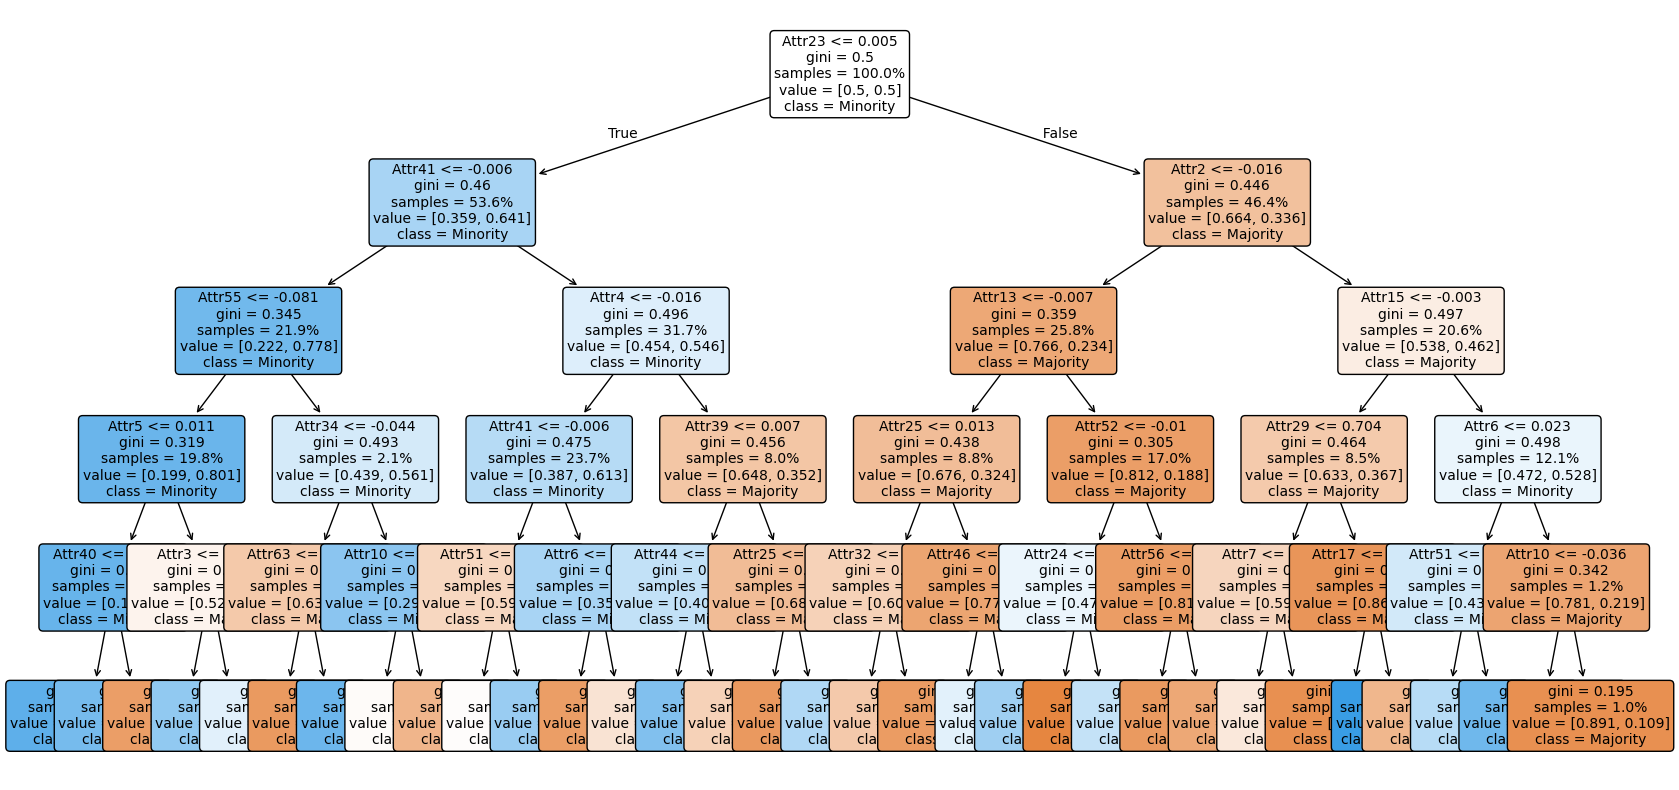

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


rf_viz = RandomForestClassifier(
    n_estimators=1,          # Only 1 tree for visualization
    max_depth=5,
    class_weight='balanced_subsample',
    random_state=42
)
rf_viz.fit(X_train_fold_resampled, y_train_fold_resampled)  
# Extract the single tree
tree = rf_viz.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=['Majority', 'Minority'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.show()

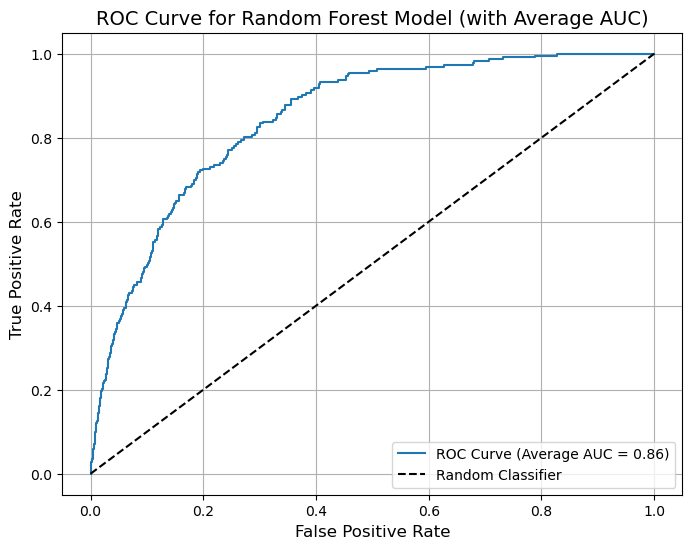

In [123]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curve for the last fold (using last fold's data)
fpr_fold, tpr_fold, thresholds_fold = roc_curve(y_test_fold, y_pred_prob_fold)

# Calculate AUC for the current fold
auc_fold = roc_auc_score(y_test_fold, y_pred_prob_fold)

# Calculate mean AUC if auc_scores_rf exists, otherwise use the current fold's AUC
if 'auc_scores_rf' in locals() and len(auc_scores_rf) > 0:
    average_auc = np.mean(auc_scores_rf)
else:
    average_auc = auc_fold

# Plot the ROC curve with the average AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr_fold, tpr_fold, label=f'ROC Curve (Average AUC = {average_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve for Random Forest Model (with Average AUC)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

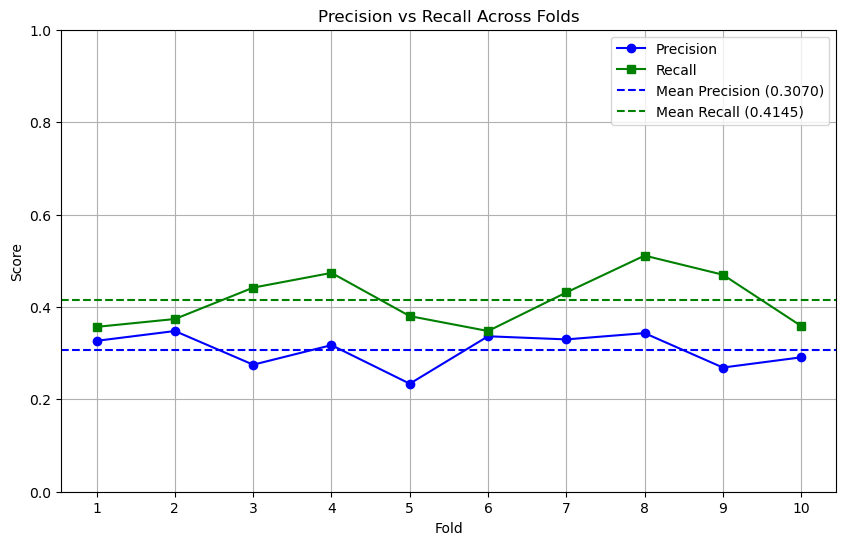

In [125]:
import matplotlib.pyplot as plt
import numpy as np


folds = np.arange(1, len(precision_scores_rf)+1)

# Plot precision and recall for each fold
plt.figure(figsize=(10,6))
plt.plot(folds, precision_scores_rf, marker='o', label='Precision', color='blue')
plt.plot(folds, recall_scores_rf, marker='s', label='Recall', color='green')

# Plot mean values as horizontal lines
mean_precision = np.mean(precision_scores_rf)
mean_recall = np.mean(recall_scores_rf)
plt.axhline(mean_precision, color='blue', linestyle='--', label=f'Mean Precision ({mean_precision:.4f})')
plt.axhline(mean_recall, color='green', linestyle='--', label=f'Mean Recall ({mean_recall:.4f})')

# Labels and title
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Precision vs Recall Across Folds')
plt.xticks(folds)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

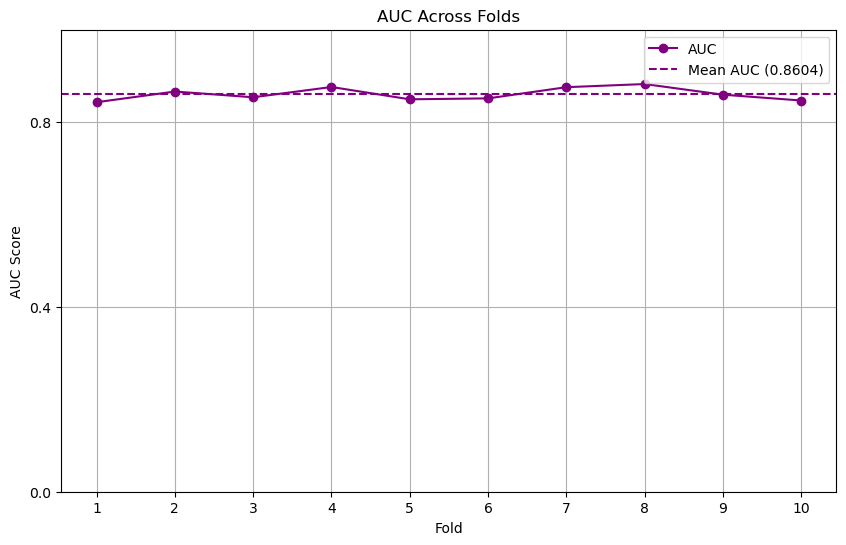

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Number of folds
folds = np.arange(1, len(auc_scores_rf)+1)

# Plot AUC for each fold
plt.figure(figsize=(10,6))
plt.plot(folds, auc_scores_rf, marker='o', color='purple', label='AUC')

# Plot mean AUC as horizontal line
mean_auc = np.mean(auc_scores_rf)
plt.axhline(mean_auc, color='purple', linestyle='--', label=f'Mean AUC ({mean_auc:.4f})')

# Labels and title
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.title('AUC Across Folds')
plt.xticks(folds)

# Set y-axis ticks every 0.4
plt.yticks(np.arange(0, 1.05, 0.4))

plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The 10-fold cross-validation on the logistic regression model resulted in the following average performance metrics across all folds:
    *   Average Accuracy: 0.7059
    *   Average Precision: 0.1010
    *   Average Recall: 0.6464
    *   Average AUC: 0.7360
*   Data inconsistencies and missing values required the imputation and scaling steps to be moved inside the cross-validation loop for correct processing.

### Insights or Next Steps

*   The high recall (0.6464) suggests the model is good at identifying positive cases, but the low precision (0.1010) indicates a high number of false positives.
*   Further model tuning or exploring different algorithms might be necessary to improve the precision while maintaining a reasonable recall and AUC.


**Reasoning**:
Use the trained Random Forest model to predict the class labels and probabilities for the scaled testing data of the current fold and display the first few results.



XGBOOST  LEARNING

In [130]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

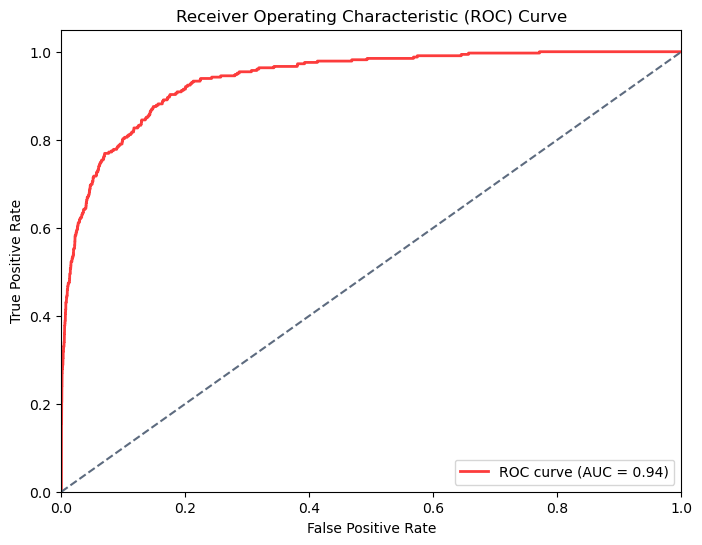


Classification Report (cutoff-0.5):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6182
           1       0.64      0.52      0.58       329

    accuracy                           0.96      6511
   macro avg       0.81      0.75      0.78      6511
weighted avg       0.96      0.96      0.96      6511


Additional Metrics:
ROC AUC: 0.9387
Accuracy: 0.9610
Precision: 0.6394
Recall: 0.5228


In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_balanced, label=y_balanced)
dtest = xgb.DMatrix(test_scaler, label=y_test_from_orig)

# Set XGBoost parameters
params = {
    'max_depth': 11,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.4).astype(int)

# Calculate metrics and plot results
fpr, tpr, _ = roc_curve(y_test_from_orig, y_pred_prob)
roc_auc = roc_auc_score(y_test_from_orig, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FC3C3C', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#5D6B7F', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print("\nClassification Report (cutoff-0.5):")
print(classification_report(y_test_from_orig, y_pred))

# Print additional metrics
print("\nAdditional Metrics:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy_score(y_test_from_orig, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_from_orig, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_from_orig, y_pred):.4f}")






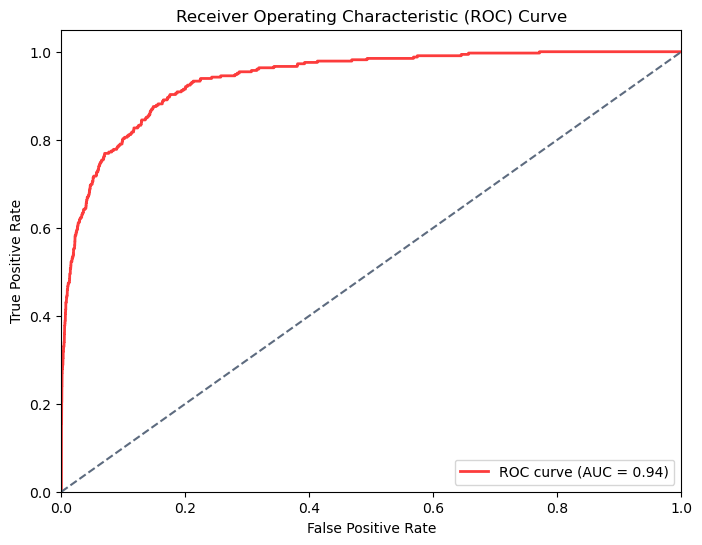


Classification Report (cutoff-0.4):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6182
           1       0.58      0.56      0.57       329

    accuracy                           0.96      6511
   macro avg       0.78      0.77      0.77      6511
weighted avg       0.96      0.96      0.96      6511


Additional Metrics:
ROC AUC: 0.9387
Accuracy: 0.9573
Precision: 0.5804
Recall: 0.5593


In [ ]:
#cutoff-0.4

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_balanced, label=y_balanced)
dtest = xgb.DMatrix(test_scaler, label=y_test_from_orig)

# Set XGBoost parameters
params = {
    'max_depth': 11,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.6).astype(int)

# Calculate metrics and plot results
fpr, tpr, _ = roc_curve(y_test_from_orig, y_pred_prob)
roc_auc = roc_auc_score(y_test_from_orig, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FC3C3C', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#5D6B7F', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print("\nClassification Report (cutoff-0.4):")
print(classification_report(y_test_from_orig, y_pred))

# Print additional metrics
print("\nAdditional Metrics:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy_score(y_test_from_orig, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_from_orig, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_from_orig, y_pred):.4f}")






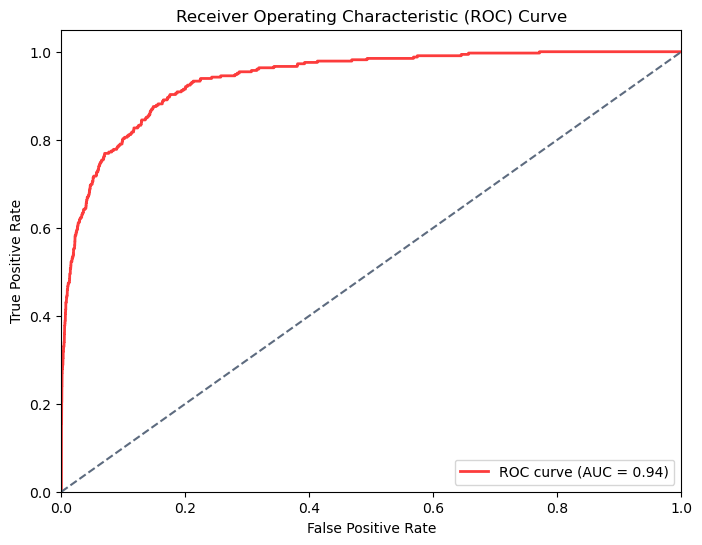


Classification Report: (cutoff-0.6)
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6182
           1       0.64      0.52      0.58       329

    accuracy                           0.96      6511
   macro avg       0.81      0.75      0.78      6511
weighted avg       0.96      0.96      0.96      6511


Additional Metrics:
ROC AUC: 0.9387
Accuracy: 0.9610
Precision: 0.6394
Recall: 0.5228


In [135]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_balanced, label=y_balanced)
dtest = xgb.DMatrix(test_scaler, label=y_test_from_orig)

# Set XGBoost parameters
params = {
    'max_depth': 11,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int) #cutoff-0.5

# Calculate metrics and plot results
fpr, tpr, _ = roc_curve(y_test_from_orig, y_pred_prob)
roc_auc = roc_auc_score(y_test_from_orig, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FC3C3C', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#5D6B7F', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print("\nClassification Report: (cutoff-0.6)")
print(classification_report(y_test_from_orig, y_pred))

# Print additional metrics
print("\nAdditional Metrics:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy_score(y_test_from_orig, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_from_orig, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_from_orig, y_pred):.4f}")






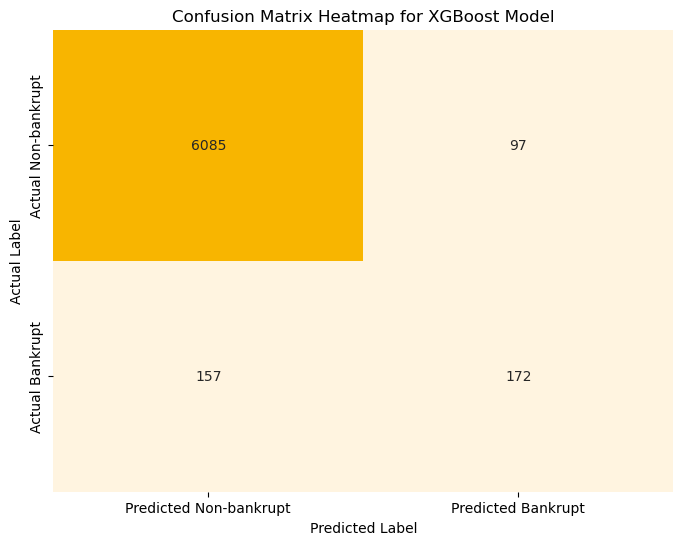

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for XGBoost predictions
conf_matrix_xgb = confusion_matrix(y_test_from_orig, y_pred)

# Use two colors from your palette
custom_cmap = sns.color_palette(['#FFF4E0', '#F8B500'], as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap=custom_cmap, cbar=False,
            xticklabels=['Predicted Non-bankrupt', 'Predicted Bankrupt'],
            yticklabels=['Actual Non-bankrupt', 'Actual Bankrupt'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Heatmap for XGBoost Model')
plt.show()


C:\Users\Sarang\AppData\Local\Temp\ipykernel_17072\3738607666.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[0, 1].plot([0, 1], [0, 1], 'k--', color='#5D6B7F')


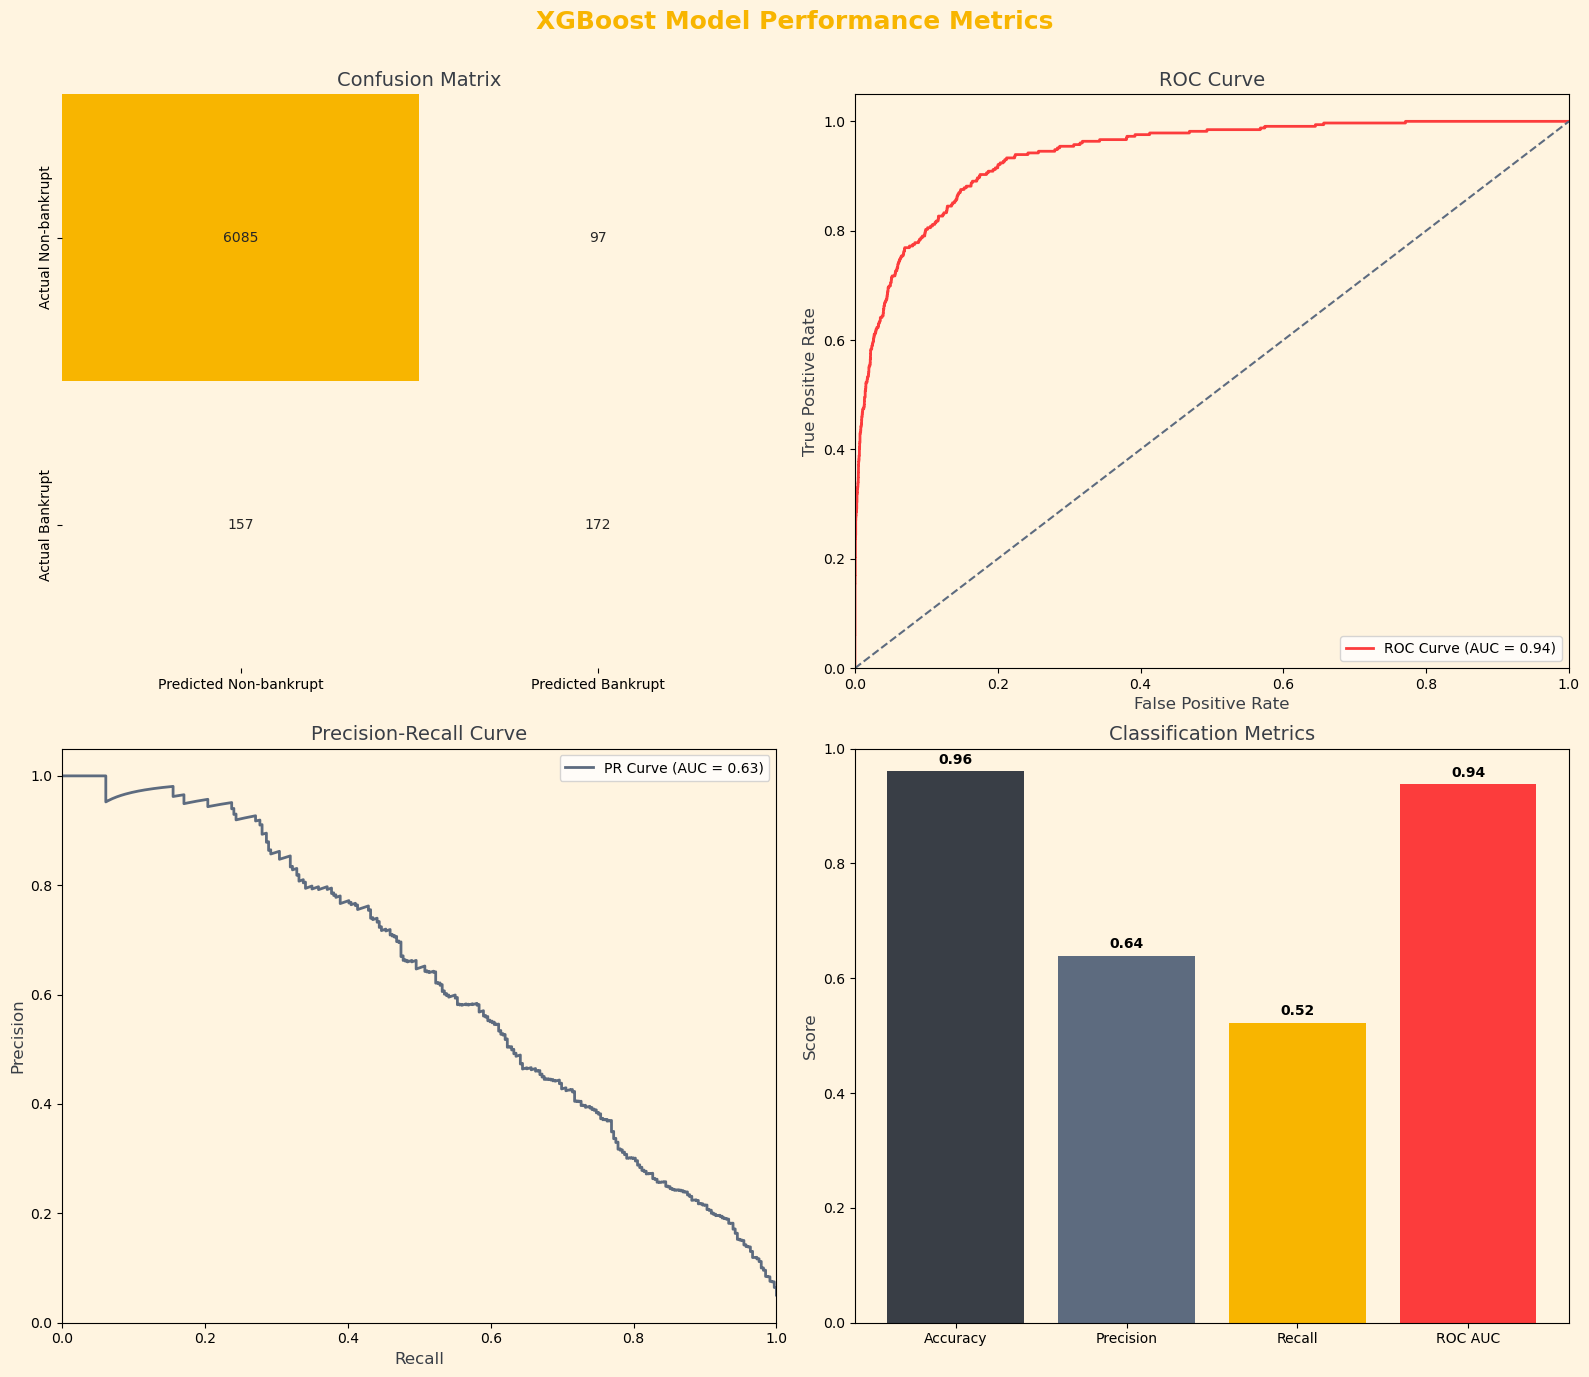

In [137]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 14), facecolor='#FFF4E0')
fig.suptitle('XGBoost Model Performance Metrics', fontsize=18, fontweight='bold', color='#F8B500')

# 1. Confusion Matrix (top-left)
cm = confusion_matrix(y_test_from_orig, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(['#FFF4E0', '#F8B500'], as_cmap=True), 
            xticklabels=['Predicted Non-bankrupt', 'Predicted Bankrupt'],
            yticklabels=['Actual Non-bankrupt', 'Actual Bankrupt'], ax=axs[0, 0], cbar=False)
axs[0, 0].set_title('Confusion Matrix', fontsize=14, color='#393E46')

# 2. ROC Curve (top-right)
fpr, tpr, _ = roc_curve(y_test_from_orig, y_pred_prob)
roc_auc = auc(fpr, tpr)
axs[0, 1].plot(fpr, tpr, color='#FC3C3C', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', color='#5D6B7F')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel('False Positive Rate', fontsize=12, color='#393E46')
axs[0, 1].set_ylabel('True Positive Rate', fontsize=12, color='#393E46')
axs[0, 1].set_title('ROC Curve', fontsize=14, color='#393E46')
axs[0, 1].legend(loc='lower right')

# 3. Precision-Recall Curve (bottom-left)
precision, recall, _ = precision_recall_curve(y_test_from_orig, y_pred_prob)
pr_auc = auc(recall, precision)
axs[1, 0].plot(recall, precision, color='#5D6B7F', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
axs[1, 0].set_xlabel('Recall', fontsize=12, color='#393E46')
axs[1, 0].set_ylabel('Precision', fontsize=12, color='#393E46')
axs[1, 0].set_title('Precision-Recall Curve', fontsize=14, color='#393E46')
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].legend(loc='upper right')

# 4. Classification Metrics Bar Chart (bottom-right)
metrics = {
    'Accuracy': accuracy_score(y_test_from_orig, y_pred),
    'Precision': precision_score(y_test_from_orig, y_pred),
    'Recall': recall_score(y_test_from_orig, y_pred),
    'ROC AUC': roc_auc
}
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())
bar_colors = [palette[i % len(palette)] for i in range(len(metrics_names))]

bars = axs[1, 1].bar(metrics_names, metrics_values, color=bar_colors)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title('Classification Metrics', fontsize=14, color='#393E46')
axs[1, 1].set_ylabel('Score', fontsize=12, color='#393E46')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    axs[1, 1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# Set all backgrounds to match the theme
for ax in axs.flat:
    ax.set_facecolor('#FFF4E0')
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

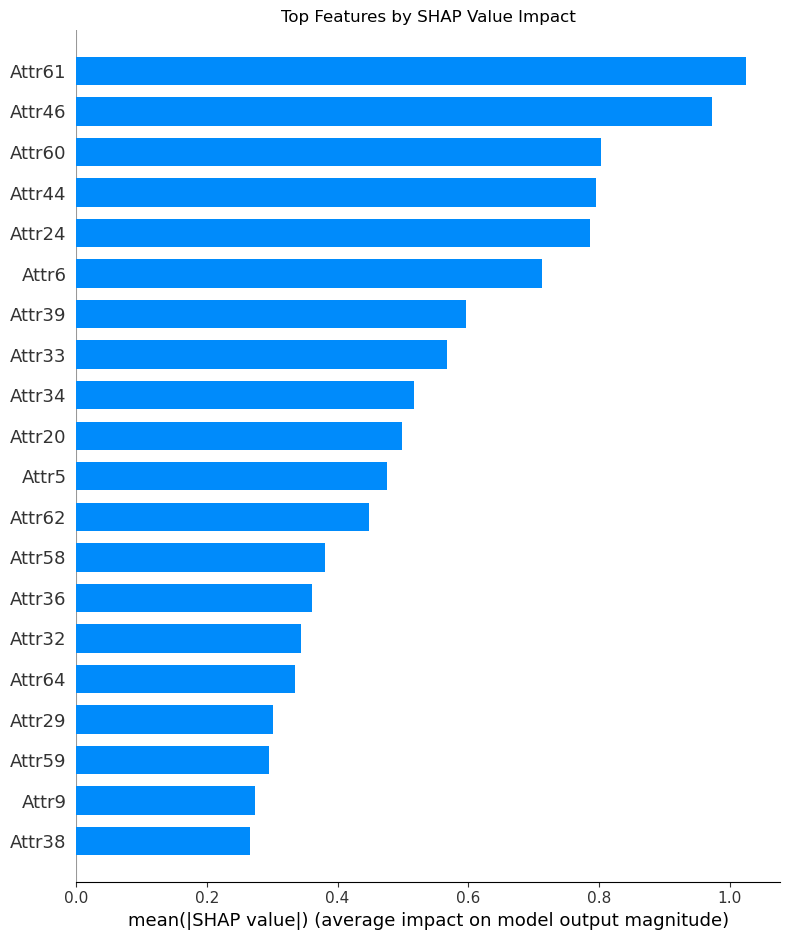


Top 10 Most Important Features:


,Feature,Importance
57,Attr61,1.025528
42,Attr46,0.972078
56,Attr60,0.802683
40,Attr44,0.795760
22,Attr24,0.785511
5,Attr6,0.712274
35,Attr39,0.596021
30,Attr33,0.567629
31,Attr34,0.516696
19,Attr20,0.498563


In [139]:
import shap

# Create explainer using the trained XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for test data
shap_values = explainer.shap_values(dtest)

# Get mean absolute SHAP values for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(0)
})

# Sort features by importance and get top 10
top_10_features = feature_importance.sort_values('Importance', ascending=False).head(10)

# Create summary plot for all features (bar plot will show top features)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_from_orig,
    plot_type="bar",
    show=False
)

plt.title("Top Features by SHAP Value Impact")
plt.tight_layout()
plt.show()

# Print the top 10 features and their importance scores
print("\nTop 10 Most Important Features:")
display(top_10_features)

In [69]:
# Get 10 indices from each class
indices_class_0 = y_test_from_orig[y_test_from_orig == 0].index[10:20]
indices_class_1 = y_test_from_orig[y_test_from_orig == 1].index[10:20]

# Get predictions for both classes
predictions_class_0 = model.predict(xgb.DMatrix(test_scaler[y_test_from_orig == 0][10:20]))
predictions_class_1 = model.predict(xgb.DMatrix(test_scaler[y_test_from_orig == 1][10:20]))

print("Predicted probabilities for Class 0 (Non-bankrupt) samples:")
for idx, prob in zip(indices_class_0, predictions_class_0):
    print(f"Index {idx}: {prob:.4f}")

print("\nPredicted probabilities for Class 1 (Bankrupt) samples:")
for idx, prob in zip(indices_class_1, predictions_class_1):
    print(f"Index {idx}: {prob:.4f}")

Predicted probabilities for Class 0 (Non-bankrupt) samples:
Index 20310: 0.0649
Index 16174: 0.0021
Index 22487: 0.0010
Index 17440: 0.0001
Index 2150: 0.0013
Index 1681: 0.0009
Index 28999: 0.0001
Index 14304: 0.0087
Index 24330: 0.0005
Index 21077: 0.0059

Predicted probabilities for Class 1 (Bankrupt) samples:
Index 6793: 0.9868
Index 27366: 0.9548
Index 27575: 0.9695
Index 6757: 0.0023
Index 6810: 0.2057
Index 6759: 0.9779
Index 17141: 0.6114
Index 37106: 0.6976
Index 6868: 0.3767
Index 43005: 0.1097


In [140]:
#Mapping of attribute names (Attr1-Attr64) to financial ratio descriptions
attr_descriptions = {
    'Attr1': 'net profit / total assets',
    'Attr2': 'total liabilities / total assets',
    'Attr3': 'working capital / total assets',
    'Attr4': 'current assets / short-term liabilities',
    'Attr5': 'liquidity_ratio',
    'Attr6': 'retained earnings / total assets',
    'Attr7': 'EBIT / total assets',
    'Attr8': 'book value of equity / total liabilities',
    'Attr9': 'sales / total assets',
    'Attr10': 'equity / total assets',
    'Attr11': '(gross profit + extraordinary items + financial expenses) / total assets',
    'Attr12': 'gross profit / short-term liabilities',
    'Attr13': '(gross profit + depreciation) / sales',
    'Attr14': '(gross profit + interest) / total assets',
    'Attr15': '(total liabilities * 365) / (gross profit + depreciation)',
    'Attr16': '(gross profit + depreciation) / total liabilities',
    'Attr17': 'total assets / total liabilities',
    'Attr18': 'gross profit / total assets',
    'Attr19': 'gross profit / sales',
    'Attr20': '(inventory * 365) / sales',
    'Attr21': 'sales (n) / sales (n-1)',
    'Attr22': 'profit on operating activities / total assets',
    'Attr23': 'net profit / sales',
    'Attr24': 'gross profit (in 3 years) / total assets',
    'Attr25': '(equity - share capital) / total assets',
    'Attr26': '(net profit + depreciation) / total liabilities',
    'Attr27': 'profit on operating activities / financial expenses',
    'Attr28': 'working capital / fixed assets',
    'Attr29': 'logarithm of total assets',
    'Attr30': '(total liabilities - cash) / sales',
    'Attr31': '(gross profit + interest) / sales',
    'Attr32': '(current liabilities * 365) / cost of products sold',
    'Attr33': 'operating expenses / short-term liabilities',
    'Attr34': 'operating expenses / total liabilities',
    'Attr35': 'profit on sales / total assets',
    'Attr36': 'total sales / total assets',
    'Attr37': '(current assets - inventories) / long-term liabilities',
    'Attr38': 'constant capital / total assets',
    'Attr39': 'profit on sales / sales',
    'Attr40': '(current assets - inventory - receivables) / short-term liabilities',
    'Attr41': 'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
    'Attr42': 'profit on operating activities / sales',
    'Attr43': 'rotation receivables + inventory turnover in days',
    'Attr44': '(receivables * 365) / sales',
    'Attr45': 'net profit / inventory',
    'Attr46': '(current assets - inventory) / short-term liabilities',
    'Attr47': '(inventory * 365) / cost of products sold',
    'Attr48': 'EBITDA (profit on operating activities - depreciation) / total assets',
    'Attr49': 'EBITDA (profit on operating activities - depreciation) / sales',
    'Attr50': 'current assets / total liabilities',
    'Attr51': 'short-term liabilities / total assets',
    'Attr52': '(short-term liabilities * 365) / cost of products sold)',
    'Attr53': 'equity / fixed assets',
    'Attr54': 'constant capital / fixed assets',
    'Attr55': 'working capital',
    'Attr56': '(sales - cost of products sold) / sales',
    'Attr57': '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)',
    'Attr58': 'total costs /total sales',
    'Attr59': 'long-term liabilities / equity',
    'Attr60': 'sales / inventory',
    'Attr61': 'sales / receivables',
    'Attr62': '(short-term liabilities *365) / sales',
    'Attr63': 'sales / short-term liabilities',
    'Attr64': 'sales / fixed assets'
}

Conclusion derived using Game Theory (SHAP, or Shapley Additive exPlanations)

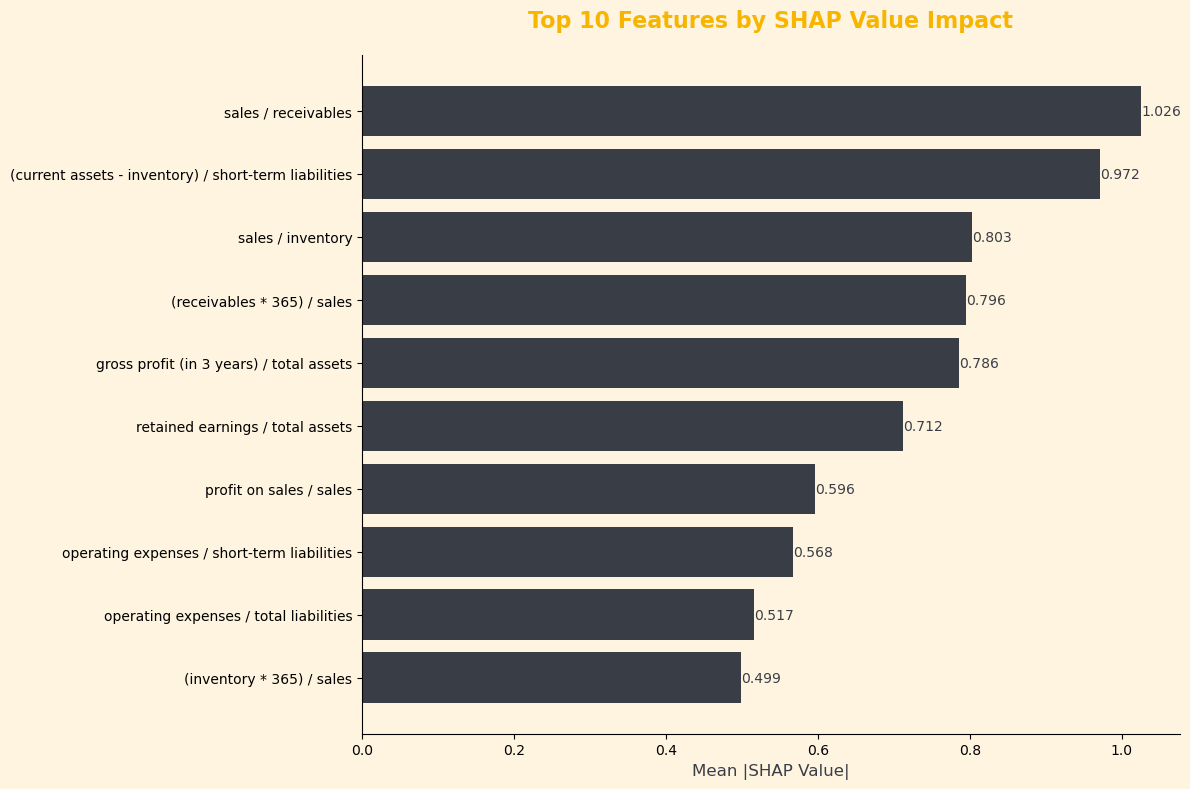

In [141]:
# Create a mapping of feature names to their descriptions
feature_descriptions = {
    feature: attr_descriptions.get(feature, feature) 
    for feature in X.columns
}

# Get top 10 features by mean absolute SHAP value
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(0)
})
top_10_features = feature_importance.sort_values('Importance', ascending=True).tail(10)

# Create the plot
plt.figure(figsize=(12, 8), facecolor='#FFF4E0')
ax = plt.gca()
ax.set_facecolor('#FFF4E0')

# Plot horizontal bars
bars = ax.barh(range(len(top_10_features)), 
               top_10_features['Importance'],
               color=palette[0])

# Add feature descriptions as labels
labels = [feature_descriptions[feat] for feat in top_10_features['Feature']]
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=10)

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center', fontsize=10,
            color='#393E46')

# Customize the plot
plt.title('Top 10 Features by SHAP Value Impact', 
          fontsize=16, fontweight='bold', color='#F8B500', pad=20)
plt.xlabel('Mean |SHAP Value|', fontsize=12, color='#393E46')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [142]:
# Get top 10 features and their SHAP values
shap_equation_features = feature_importance.sort_values('Importance', ascending=False).head(10)

# Create equation string
equation = "Bankruptcy Risk = "
terms = []

for idx, row in shap_equation_features.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    desc = attr_descriptions.get(feature, feature)
    term = f"({importance:.3f} × {desc})"
    terms.append(term)

equation += " + ".join(terms)

print("XGBoost Model Equation Based on SHAP Values:")
print(equation)

XGBoost Model Equation Based on SHAP Values:
Bankruptcy Risk = (1.026 × sales / receivables) + (0.972 × (current assets - inventory) / short-term liabilities) + (0.803 × sales / inventory) + (0.796 × (receivables * 365) / sales) + (0.786 × gross profit (in 3 years) / total assets) + (0.712 × retained earnings / total assets) + (0.596 × profit on sales / sales) + (0.568 × operating expenses / short-term liabilities) + (0.517 × operating expenses / total liabilities) + (0.499 × (inventory * 365) / sales)


C:\Users\Sarang\AppData\Local\Temp\ipykernel_17072\4043325077.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([
C:\Users\Sarang\AppData\Local\Temp\ipykernel_17072\4043325077.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([
C:\Users\Sarang\AppData\Local\Temp\ipykernel_17072\4043325077.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([
C:\Users\Sarang\AppData\Local\Temp\ipykernel_17072\4043325077.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old nam

<Figure size 1500x800 with 0 Axes>

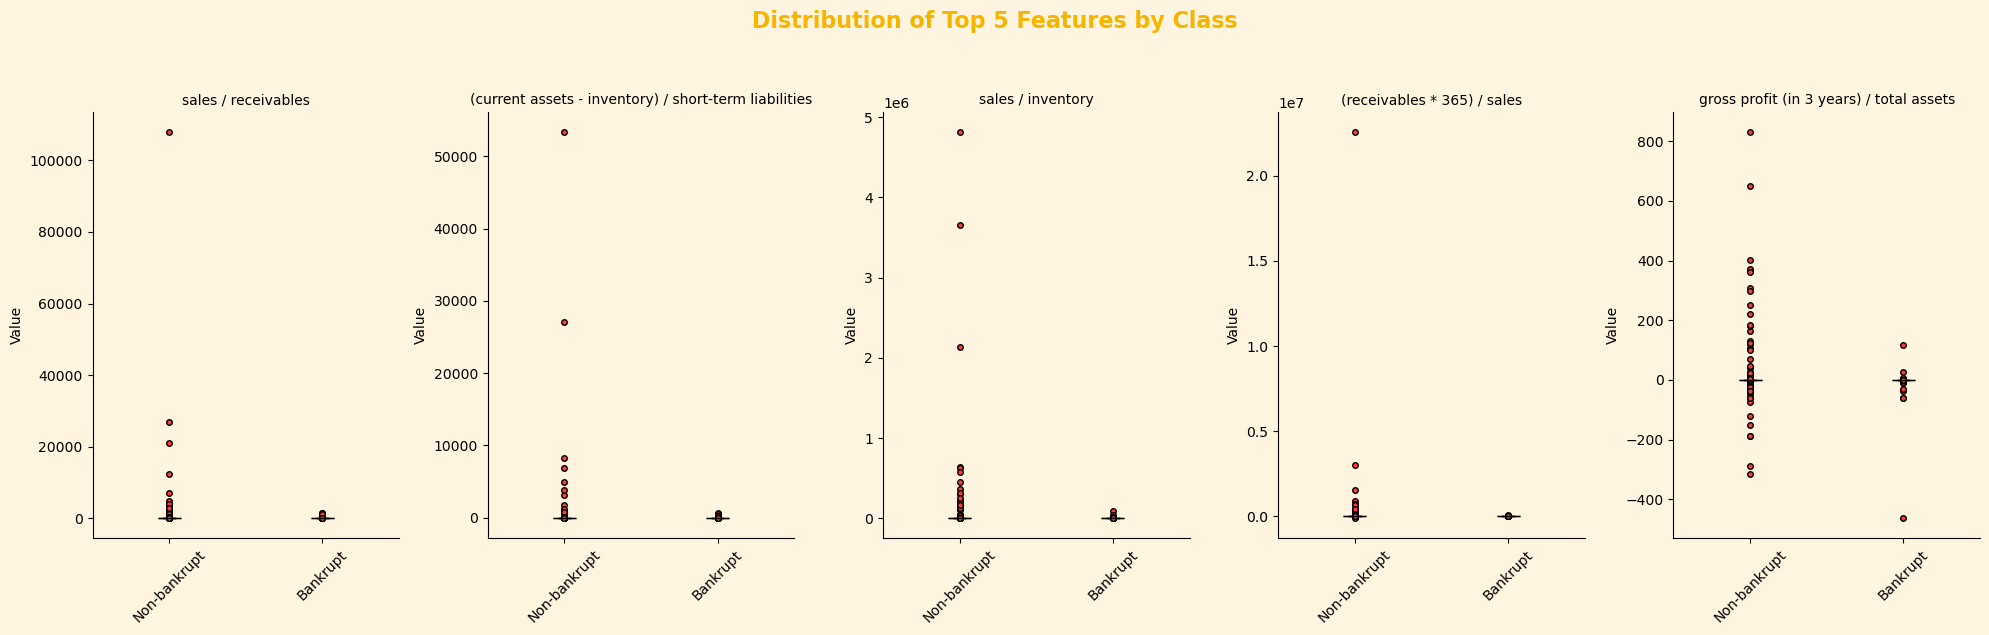

In [143]:
# Get the top 5 features from the SHAP analysis
top_5_features = feature_importance.nlargest(5, 'Importance')['Feature'].tolist()

# Create subplots for the boxplots
plt.figure(figsize=(15, 8), facecolor='#FFF4E0')
fig, axes = plt.subplots(1, 5, figsize=(20, 6), facecolor='#FFF4E0')
fig.suptitle('Distribution of Top 5 Features by Class', fontsize=16, fontweight='bold', color='#F8B500', y=1.05)

# Create boxplots for each feature
for i, feature in enumerate(top_5_features):
    # Create boxplot
    axes[i].set_facecolor('#FFF4E0')
    bp = axes[i].boxplot([
        df[df['class'] == 0][feature],
        df[df['class'] == 1][feature]
    ], labels=['Non-bankrupt', 'Bankrupt'],
    patch_artist=True,
    medianprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='#FC3C3C', markersize=4))
    
    # Customize boxplot colors
    colors = ['#393E46', '#F8B500']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Set title and labels
    axes[i].set_title(attr_descriptions.get(feature, feature), fontsize=10, wrap=True)
    axes[i].set_ylabel('Value')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

This is our additional research where we also wanted to know , if a factor is positively impacting the model's performance or negatively?

It illustrates how each feature's contribution, represented by its SHAP value, moves the model's output from the expected base value to the final prediction for that specific instance.
Key components and interpretation:
Expected Base Value (E[f(x)]): This represents the average or expected output of the model over a background dataset. The plot begins at this value.
Feature Contributions (SHAP Values): Each row in the waterfall plot corresponds to a feature. An bar indicates the SHAP value for that feature, showing its positive (Yellow) or negative (red) contribution to the prediction. yellow bar push the prediction higher, while red bar pull it lower.


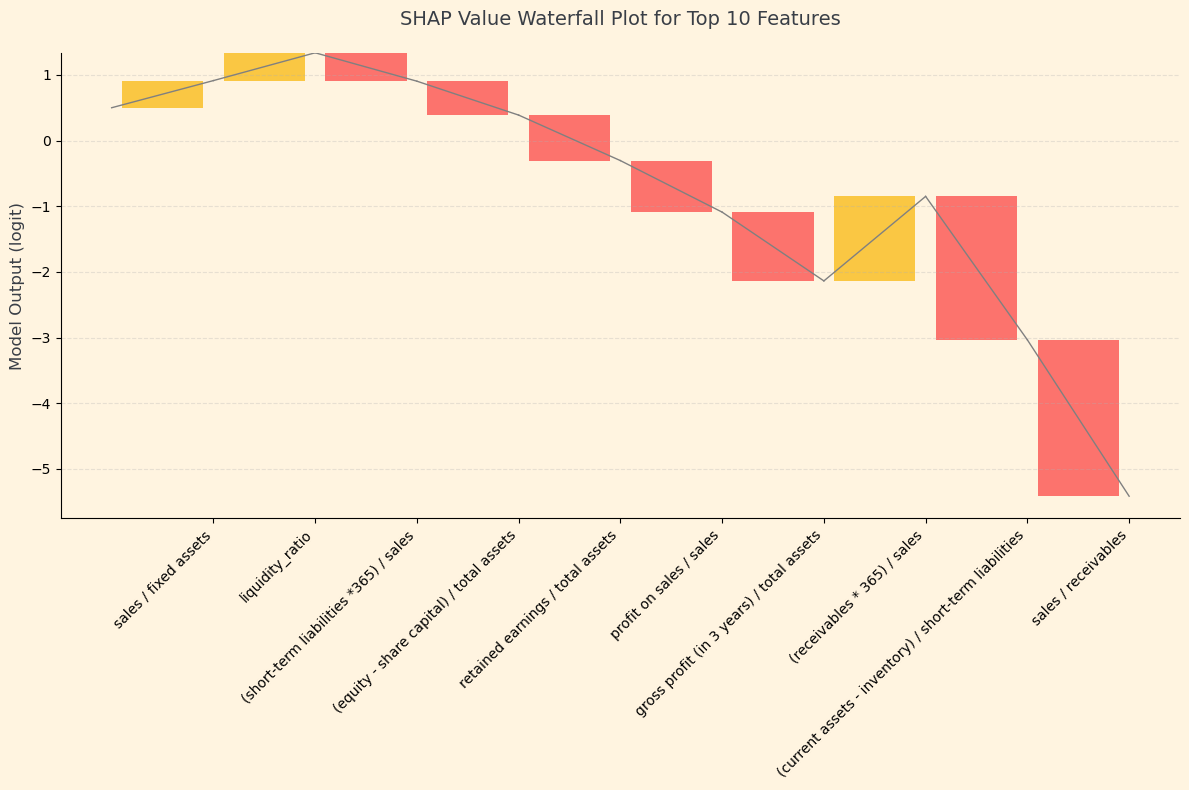


Feature values for this sample:
sales / fixed assets: Value = 16.3530, SHAP Impact = 0.4135
liquidity_ratio: Value = 75.4240, SHAP Impact = 0.4237
(short-term liabilities *365) / sales: Value = 61.2840, SHAP Impact = -0.4327
(equity - share capital) / total assets: Value = 0.6626, SHAP Impact = -0.5165
retained earnings / total assets: Value = 0.0000, SHAP Impact = -0.6932
profit on sales / sales: Value = 0.1052, SHAP Impact = -0.7851
gross profit (in 3 years) / total assets: Value = 0.5452, SHAP Impact = -1.0476
(receivables * 365) / sales: Value = 126.6900, SHAP Impact = 1.2873
(current assets - inventory) / short-term liabilities: Value = 2.1018, SHAP Impact = -2.1855
sales / receivables: Value = 2.8811, SHAP Impact = -2.3814


In [144]:
import numpy as np

import matplotlib.pyplot as plt

# Get sample index for demonstration (using first test sample)
sample_index = 0

# Get SHAP values for this sample
sample_shap_values = shap_values[sample_index]

# Get feature names and values for this sample
feature_names = X.columns
sample_values = X_test_from_orig.iloc[sample_index]

# Get top 10 features by absolute SHAP value for this sample
top_10_indices = np.argsort(np.abs(sample_shap_values))[-10:]
top_10_shap = sample_shap_values[top_10_indices]
top_10_names = [attr_descriptions.get(feature_names[i], feature_names[i]) for i in top_10_indices]
top_10_values = sample_values.iloc[top_10_indices]

# Create the waterfall plot
fig, ax = plt.subplots(figsize=(12, 8), facecolor='#FFF4E0')
ax.set_facecolor('#FFF4E0')

# Starting point (base value)
base_value = 0.5  # assuming sigmoid activation
current = base_value

# Plot bars
for i, (name, shap_value) in enumerate(zip(top_10_names, top_10_shap)):
    # Plot connecting line
    ax.plot([i, i+1], [current, current + shap_value], color='gray', linestyle='-', linewidth=1)
    
    # Plot impact bar
    if shap_value > 0:
        ax.bar(i+0.5, shap_value, bottom=current, color='#F8B500', alpha=0.7, width=0.8)
    else:
        ax.bar(i+0.5, shap_value, bottom=current, color='#FC3C3C', alpha=0.7, width=0.8)
    
    current += shap_value

# Customize plot
plt.xticks(range(1, len(top_10_names) + 1), top_10_names, rotation=45, ha='right')
plt.title('SHAP Value Waterfall Plot for Top 10 Features', fontsize=14, color='#393E46', pad=20)
plt.ylabel('Model Output (logit)', fontsize=12, color='#393E46')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print feature values
print("\nFeature values for this sample:")
for name, value, shap_value in zip(top_10_names, top_10_values, top_10_shap):
    print(f"{name}: Value = {value:.4f}, SHAP Impact = {shap_value:.4f}")

Catboost model just to add check for the variablity in boosting models

CatBoost Accuracy: 0.9406
CatBoost Precision: 0.4378
CatBoost Recall: 0.6201
CatBoost ROC AUC: 0.9302

Classification Report:
               precision    recall  f1-score   support

Non-bankrupt       0.98      0.96      0.97      6182
    Bankrupt       0.44      0.62      0.51       329

    accuracy                           0.94      6511
   macro avg       0.71      0.79      0.74      6511
weighted avg       0.95      0.94      0.95      6511



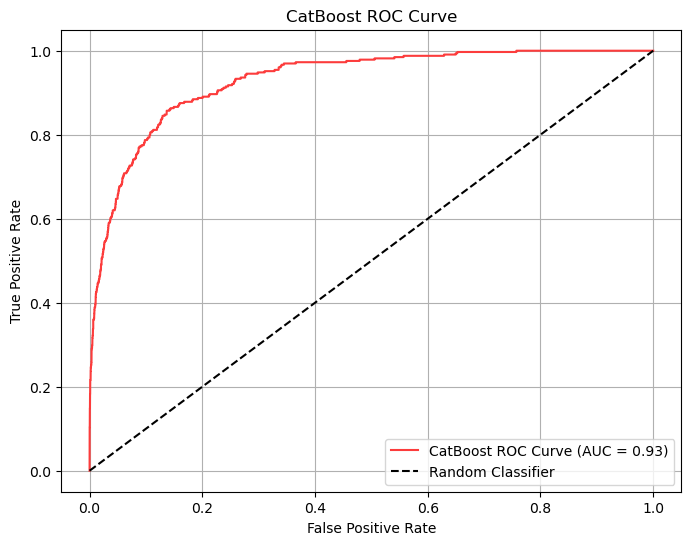

In [146]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
import seaborn as sns

import matplotlib.pyplot as plt

# Train CatBoost model
cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=8,
    eval_metric='AUC',
    verbose=0,
    random_seed=42
)
cat_model.fit(X_balanced, y_balanced)

# Predict probabilities and labels on test set
y_pred_prob_cat = cat_model.predict_proba(test_scaler)[:, 1]
y_pred_cat = (y_pred_prob_cat > 0.5).astype(int)

# Metrics
accuracy_cat = accuracy_score(y_test_from_orig, y_pred_cat)
precision_cat = precision_score(y_test_from_orig, y_pred_cat)
recall_cat = recall_score(y_test_from_orig, y_pred_cat)
auc_cat = roc_auc_score(y_test_from_orig, y_pred_prob_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost Precision: {precision_cat:.4f}")
print(f"CatBoost Recall: {recall_cat:.4f}")
print(f"CatBoost ROC AUC: {auc_cat:.4f}")
print("\nClassification Report:\n", classification_report(y_test_from_orig, y_pred_cat, target_names=['Non-bankrupt', 'Bankrupt']))

# ROC Curve
fpr_cat, tpr_cat, _ = roc_curve(y_test_from_orig, y_pred_prob_cat)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost ROC Curve (AUC = {auc_cat:.2f})', color='#FC3C3C')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Sarang\AppData\Local\Temp\ipykernel_2512\1036443955.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[0, 1].plot([0, 1], [0, 1], 'k--', color='#5D6B7F')


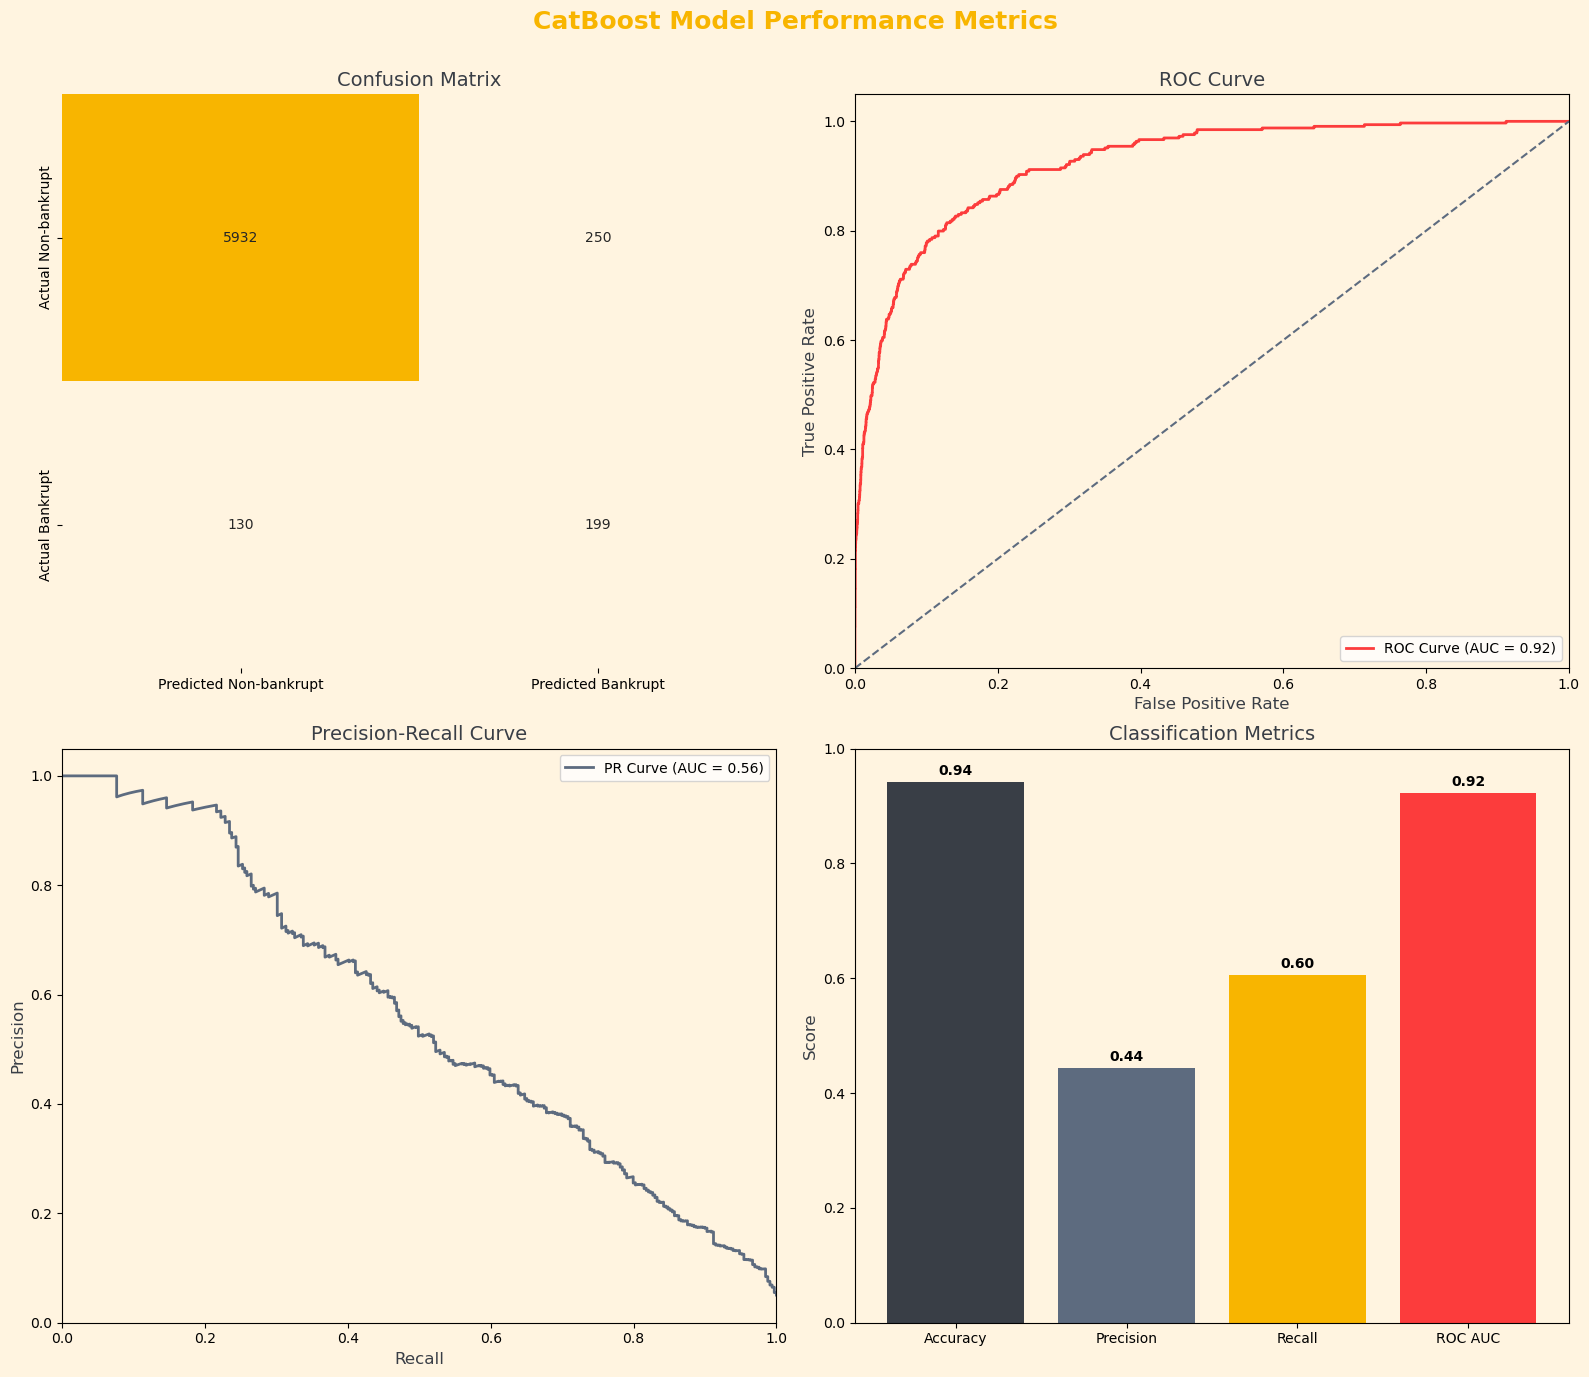

In [185]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 14), facecolor='#FFF4E0')
fig.suptitle('CatBoost Model Performance Metrics', fontsize=18, fontweight='bold', color='#F8B500')

# 1. Confusion Matrix (top-left)
cm = confusion_matrix(y_test_from_orig, y_pred_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(['#FFF4E0', '#F8B500'], as_cmap=True), 
            xticklabels=['Predicted Non-bankrupt', 'Predicted Bankrupt'],
            yticklabels=['Actual Non-bankrupt', 'Actual Bankrupt'], ax=axs[0, 0], cbar=False)
axs[0, 0].set_title('Confusion Matrix', fontsize=14, color='#393E46')

# 2. ROC Curve (top-right)
fpr_cat, tpr_cat, _ = roc_curve(y_test_from_orig, y_pred_prob_cat)
roc_auc = auc(fpr_cat, tpr_cat)
axs[0, 1].plot(fpr_cat, tpr_cat, color='#FC3C3C', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', color='#5D6B7F')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel('False Positive Rate', fontsize=12, color='#393E46')
axs[0, 1].set_ylabel('True Positive Rate', fontsize=12, color='#393E46')
axs[0, 1].set_title('ROC Curve', fontsize=14, color='#393E46')
axs[0, 1].legend(loc='lower right')

# 3. Precision-Recall Curve (bottom-left)
precision, recall, _ = precision_recall_curve(y_test_from_orig, y_pred_prob_cat)
pr_auc = auc(recall, precision)
axs[1, 0].plot(recall, precision, color='#5D6B7F', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
axs[1, 0].set_xlabel('Recall', fontsize=12, color='#393E46')
axs[1, 0].set_ylabel('Precision', fontsize=12, color='#393E46')
axs[1, 0].set_title('Precision-Recall Curve', fontsize=14, color='#393E46')
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].legend(loc='upper right')

# 4. Classification Metrics Bar Chart (bottom-right)
metrics = {
    'Accuracy': accuracy_cat,
    'Precision': precision_cat,
    'Recall': recall_cat,
    'ROC AUC': auc_cat
}
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())
bar_colors = [palette[i % len(palette)] for i in range(len(metrics_names))]

bars = axs[1, 1].bar(metrics_names, metrics_values, color=bar_colors)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title('Classification Metrics', fontsize=14, color='#393E46')
axs[1, 1].set_ylabel('Score', fontsize=12, color='#393E46')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    axs[1, 1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# Set all backgrounds to match the theme
for ax in axs.flat:
    ax.set_facecolor('#FFF4E0')
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Catboost shows, not significant changes as compared to xgboost, so our conclusions are based on XGBoost